# **The Vehicle Type Classification Project**



# Summary


- **Use Case:** Vehicle Type
- **Algorithm:** MobileNetV2
- **Number of training images:** 603
- **Number of classes:** 7
- **Batch Size:** 64
- **Optimizer:** Adam 
- **Learning Rate:** 0.0001
- **Loss Type:**CategoricalCrossentropy
- **Transfer Learning:** Yes | Imagenet



 ## Labels
 
 0: 'car-bus-alltypes',

 1: 'car-sedan-alltypes',
 
 2: 'car-suv-alltypes',
 
 3: 'motocycle-bicycle-kids',
 
 4: 'motocycle-bicycle-racing',
 
 5: 'motocycle-motorbike-chopper',
 
 6: 'motocycle-motorbike-sport'

## Import Library

In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
#from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import sys
import tensorflow as tf
import h5py
import numpy as np
import sys

In [2]:
print(tf.__version__)

2.8.2


## 구글드라이브 마운트 하기

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 워킹 디렉토리 경로 셋팅
os.chdir('/content/drive/MyDrive/kdigital2/deeplearning')

In [6]:
# 데이터 파일 다운로드

!wget --no-check-certificate \
 https://block-yh-test1.s3.amazonaws.com/38_%E1%84%89%E1%85%B5%E1%86%AF%E1%84%89%E1%85%B3%E1%86%B8%E1%84%91%E1%85%A1%E1%84%8B%E1%85%B5%E1%86%AF.zip \
  -O ./data.zip

--2022-06-16 05:34:22--  https://block-yh-test1.s3.amazonaws.com/38_%E1%84%89%E1%85%B5%E1%86%AF%E1%84%89%E1%85%B3%E1%86%B8%E1%84%91%E1%85%A1%E1%84%8B%E1%85%B5%E1%86%AF.zip
Resolving block-yh-test1.s3.amazonaws.com (block-yh-test1.s3.amazonaws.com)... 52.216.35.249
Connecting to block-yh-test1.s3.amazonaws.com (block-yh-test1.s3.amazonaws.com)|52.216.35.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 326052257 (311M) [application/zip]
Saving to: ‘./data.zip’

./data.zip          100%[===================>] 310.95M  63.8MB/s    in 4.9s    

2022-06-16 05:34:27 (63.6 MB/s) - ‘./data.zip’ saved [326052257/326052257]



In [7]:
! unzip data.zip

Archive:  data.zip
   creating: test-images/
  inflating: __MACOSX/._test-images  
  inflating: test-images/bicycle.png  
  inflating: __MACOSX/test-images/._bicycle.png  
  inflating: test-images/bus.jpg     
  inflating: __MACOSX/test-images/._bus.jpg  
   creating: trained-models/
  inflating: __MACOSX/._trained-models  
   creating: trained-models/mobilenetv2/
  inflating: __MACOSX/trained-models/._mobilenetv2  
  inflating: trained-models/mobilenetv2/vehicle-classification-by-type-mobilenetv2-anis-1.h5  
  inflating: __MACOSX/trained-models/mobilenetv2/._vehicle-classification-by-type-mobilenetv2-anis-1.h5  
  inflating: trained-models/mobilenetv2/vehicle-classification-by-type-mobilenetv2-anis-1-2.h5  
  inflating: __MACOSX/trained-models/mobilenetv2/._vehicle-classification-by-type-mobilenetv2-anis-1-2.h5  
  inflating: trained-models/mobilenetv2/vehicle-classification-by-type-mobilenetv2-anis-2.h5  
  inflating: __MACOSX/trained-models/mobilenetv2/._vehicle-classification-by-ty

## 경로 셋팅

In [8]:
TYPE='type'
model_type='mobilenetv2'
user='block'
iteration='1-1'

first_time_training=True

PROJECT_PATH= '.'

HDF5_DATASET_PATH=PROJECT_PATH+'/vehicle_datasets/vehicle-type-dataset-SIZE224-train-dev-test-v2.hdf5'

TARGET_CLASSIFICATION_MODEL=PROJECT_PATH+'/trained-models/'+model_type+'/'+'vehicle-classification-by-'+TYPE+'-'+model_type+'-'+user+'-'+iteration+'.h5'

CHECKPOINT_PATH = PROJECT_PATH+'/checkpoints/'+model_type+'/'+'by-'+TYPE+'-'+model_type+'-'+user+'-'+iteration+'.h5'

LOGFILE_PATH=PROJECT_PATH+'/log/'+model_type+'/'+model_type+'-by-'+TYPE+'-training-log'+user+'-'+iteration+'.csv'


In [9]:
print('PROJECT_PATH: ',PROJECT_PATH)
print('HDF5_DATASET_PATH: ', HDF5_DATASET_PATH)
print('TARGET_CLASSIFICATION_MODEL: ',TARGET_CLASSIFICATION_MODEL)
print('CHECKPOINT_PATH: ',CHECKPOINT_PATH)
print('LOGFILE_PATH: ',LOGFILE_PATH)

PROJECT_PATH:  .
HDF5_DATASET_PATH:  ./vehicle_datasets/vehicle-type-dataset-SIZE224-train-dev-test-v2.hdf5
TARGET_CLASSIFICATION_MODEL:  ./trained-models/mobilenetv2/vehicle-classification-by-type-mobilenetv2-block-1-1.h5
CHECKPOINT_PATH:  ./checkpoints/mobilenetv2/by-type-mobilenetv2-block-1-1.h5
LOGFILE_PATH:  ./log/mobilenetv2/mobilenetv2-by-type-training-logblock-1-1.csv


In [ ]:

sys.path.append(PROJECT_PATH)


# **Load the Dataset**

In [10]:
def load_dataset_from_hdf5_file(hdf_file_path):
  # 함수 만들기
  hf = h5py.File(hdf_file_path, 'r')

  X_train = np.array(hf['trainX'])
  y_train = np.array(hf['trainY'])
  train_label = np.array(hf['trainLabels'])

  X_test = np.array(hf['testX'])
  y_test = np.array(hf['testY'])
  test_label = np.array(hf['testLabels'])

  X_val = np.array(hf['devX'])
  y_val = np.array(hf['devY'])
  val_label = np.array(hf['devLabels'])

  return X_train, y_train, train_label, X_test, y_test, test_label, X_val, y_val, val_label
  

In [11]:
X_train, y_train, train_label, X_test, y_test, test_label, X_val, y_val, val_label=load_dataset_from_hdf5_file(HDF5_DATASET_PATH)

In [12]:
X_train

array([[[[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        ...,

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]

In [13]:
y_train

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [14]:
train_label

array([b'motocycle-motorbike-chopper', b'motocycle-motorbike-chopper',
       b'motocycle-bicycle-racing', b'car-suv-alltypes',
       b'motocycle-motorbike-sport', b'motocycle-bicycle-racing',
       b'car-suv-alltypes', b'car-suv-alltypes', b'car-bus-alltypes',
       b'car-bus-alltypes', b'car-bus-alltypes', b'car-bus-alltypes',
       b'motocycle-motorbike-chopper', b'motocycle-bicycle-kids',
       b'motocycle-bicycle-kids', b'motocycle-bicycle-kids',
       b'motocycle-bicycle-kids', b'motocycle-motorbike-chopper',
       b'motocycle-bicycle-racing', b'motocycle-motorbike-chopper',
       b'motocycle-motorbike-chopper', b'car-suv-alltypes',
       b'motocycle-motorbike-sport', b'motocycle-motorbike-sport',
       b'car-bus-alltypes', b'car-sedan-alltypes',
       b'motocycle-bicycle-kids', b'motocycle-motorbike-sport',
       b'motocycle-motorbike-chopper', b'car-suv-alltypes',
       b'motocycle-bicycle-kids', b'car-suv-alltypes',
       b'car-bus-alltypes', b'motocycle-motorbik

In [15]:
X_train.shape

(603, 224, 224, 3)

In [16]:
X_test.shape

(76, 224, 224, 3)

In [17]:
X_val.shape

(75, 224, 224, 3)

# 사진이미지 확인해 보기

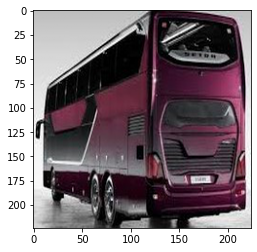

In [23]:
plt.imshow( X_train[10] )
plt.show()

In [24]:
y_train[10]

array([1, 0, 0, 0, 0, 0, 0])

In [25]:
train_label[10]

b'car-bus-alltypes'

In [26]:
# 이 데이터는 이미 피쳐스케일링 되어있다!

In [27]:
X_train.max()

1.0

In [28]:
X_train.min()

0.0

# 모델링하기 : 트랜스퍼 러닝 적용

# Data Augmentation

In [29]:
X_train.shape

(603, 224, 224, 3)

In [32]:
base_model = MobileNetV2(input_shape = (224,224,3) , include_top= False)

9420800/9406464 [==============================] - 0s 0us/step


In [33]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [34]:
base_model.trainable = False

In [35]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [37]:
head_model = base_model.output

In [38]:
head_model = AveragePooling2D( 4,  4)(head_model)

In [39]:
head_model = Flatten()(head_model)

In [40]:
head_model = Dense(128, 'relu')(head_model)

In [41]:
head_model = Dropout(0.4)(head_model)

In [42]:
head_model = Dense(64, 'relu')(head_model)

In [43]:
head_model = Dense(7, 'softmax')(head_model)

In [44]:
model = Model(inputs = base_model.input,  outputs = head_model )

###  콜백 만들기 : 가장 좋은 모델을 자동 저장하도록 함. 로그도 저장하도록 함.

In [47]:
# 파이썬으로 디렉토리 만드는 코드 작성
if not os.path.exists(PROJECT_PATH + '/checkpoints/' + model_type + '/') :
  os.makedirs(PROJECT_PATH + '/checkpoints/' + model_type + '/')

if not os.path.exists(PROJECT_PATH + '/log/' + model_type + '/') :
  os.makedirs(PROJECT_PATH + '/log/' + model_type + '/')

In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [48]:
CHECKPOINT_PATH

'./checkpoints/mobilenetv2/by-type-mobilenetv2-block-1-1.h5'

In [49]:
cp = ModelCheckpoint(CHECKPOINT_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)

In [51]:
# 에포크가 끝날때 나오는 정보를, 파일로 저장할때 사용 
from tensorflow.keras.callbacks import CSVLogger

In [52]:
LOGFILE_PATH

'./log/mobilenetv2/mobilenetv2-by-type-training-logblock-1-1.csv'

In [53]:
csv_logger = CSVLogger(LOGFILE_PATH, append=True )

## 컴파일과 학습 : 에포크는 50

In [54]:
y_train

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [55]:
model.compile(Adam(0.0001), 'categorical_crossentropy', ['accuracy'] )

In [56]:
# 학습 이미지 증강을 위해서 ImageDataGenerator 을 사용

In [57]:
X_train.max()

1.0

In [58]:
train_datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True)

In [59]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=64)

In [60]:
from gc import callbacks
epoch_history = model.fit(train_generator , epochs = 40 , validation_data=(X_val, y_val) ,
                          callbacks = [cp , csv_logger], steps_per_epoch = 10)

Epoch 1/40
10/10 [==============================] - ETA: 0s - loss: 2.1616 - accuracy: 0.1642
Epoch 1: val_accuracy improved from -inf to 0.42667, saving model to ./checkpoints/mobilenetv2/by-type-mobilenetv2-block-1-1.h5
10/10 [==============================] - 21s 760ms/step - loss: 2.1616 - accuracy: 0.1642 - val_loss: 1.7125 - val_accuracy: 0.4267
Epoch 2/40
10/10 [==============================] - ETA: 0s - loss: 1.7438 - accuracy: 0.2852
Epoch 2: val_accuracy improved from 0.42667 to 0.50667, saving model to ./checkpoints/mobilenetv2/by-type-mobilenetv2-block-1-1.h5
10/10 [==============================] - 6s 682ms/step - loss: 1.7438 - accuracy: 0.2852 - val_loss: 1.4204 - val_accuracy: 0.5067
Epoch 3/40
10/10 [==============================] - ETA: 0s - loss: 1.4967 - accuracy: 0.4444
Epoch 3: val_accuracy improved from 0.50667 to 0.62667, saving model to ./checkpoints/mobilenetv2/by-type-mobilenetv2-block-1-1.h5
10/10 [==============================] - 7s 653ms/step - loss: 1.

In [63]:
X_train.shape

(603, 224, 224, 3)

In [62]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 200ms/step - loss: 0.1562 - accuracy: 0.9737


[0.1561751663684845, 0.9736841917037964]

# 트레이닝 및 밸리데이션의 정확도와 로스를 차트로 보기

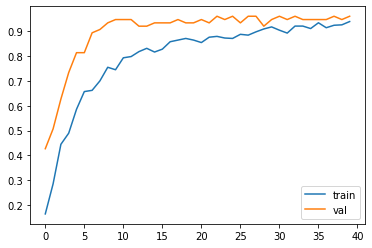

In [67]:
plt.plot(epoch_history.history['accuracy'])
plt.plot(epoch_history.history['val_accuracy'])
plt.legend(['train', 'val'])
plt.show()

In [68]:
### fine tuning 한다.

# 모델 평가